<a href="https://colab.research.google.com/github/FrancescoMonaco/LFN_Project/blob/francesco_branch/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval


In [1]:
!pip install nilearn
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 52.5 MB/s eta 0:00:00


In [2]:
#@title Imports
#*** Libraries to manipulate fMRI data
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
#*** Libraries for graphs
import networkx as nx
#*** Basic imports
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import gc, os
from tqdm.notebook import tqdm
#*** Covariance estimator
from sklearn.preprocessing import StandardScaler



In [3]:
#@title Data download

# Load the brain atlas
atlas = datasets.fetch_atlas_msdl()
# Load the atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Load atlas data stored in 'labels'
labels = atlas["labels"]

# Load the dataset
_, urls = datasets.fetch_ds000030_urls()

selected_subjects = [
    'sub-10159', 'sub-10171', 'sub-10189', 'sub-10206', 'sub-10217',
    'sub-10292', 'sub-10524', 'sub-10316', 'sub-10940', 'sub-11156',
    'sub-50004', 'sub-50005', 'sub-50006', 'sub-50007', 'sub-50008',
    'sub-50010', 'sub-50013', 'sub-50014', 'sub-50015', 'sub-50016',
    'sub-60001', 'sub-60005', 'sub-60006', 'sub-60008', 'sub-60010',
    'sub-60011', 'sub-60012', 'sub-60014', 'sub-60015', 'sub-60016',
    'sub-70017', 'sub-70020', 'sub-70021', 'sub-70022', 'sub-70026',
    'sub-70029', 'sub-70033', 'sub-70034', 'sub-70083', 'sub-70086'
]

filtered_urls = [url for url in urls if any(subject in url for subject in selected_subjects)]

# Define exclusion patterns to exclude unwanted data
exclusion_patterns = [
    "*/freesurfer/*"
    "*derivatives/task*",
    "*task_group*",
    "*/anat/*",
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-pamenc*",
    "*task-pamret*",
    "*task-scap*",
    "*task-task*",
    "*task-stopsignal*",
    "*task-bht*"
]

# Apply the filters to select subjects and exclude unwanted data
urls = datasets.select_from_index(
    filtered_urls, exclusion_filters=exclusion_patterns
)

try:
    # Fetch the selected subjects' data
    data_dir, _ = datasets.fetch_openneuro_dataset(urls=urls)
except Exception as e:
    print(f"Finished, except: {e}")



Dataset created in /root/nilearn_data/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.



Dataset created in /root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed



Downloaded 54673408 of 58172802 bytes (94.0%,    0.7s remaining) ...done. (15 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 76840960 of 100027401 bytes (76.8%,    0.3s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 68141056 of 97652235 bytes (69.8%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 63143936 of 97577603 bytes (64.7%,    0.5s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 80658432 of 100405816 bytes (80.3%,    0.5s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 98438748 bytes (54.3%,    0.9s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 73867264 of 105837055 bytes (69.8%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 69009408 of 94517910 bytes (73.0%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53010432 of 84839826 bytes (62.5%,    0.6s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 74547200 of 102343755 bytes (72.8%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 93503488 of 94610109 bytes (98.8%,    0.0s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 67043328 of 93257326 bytes (71.9%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71262208 of 96105929 bytes (74.1%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 80904192 of 106193076 bytes (76.2%,    0.7s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71262208 of 102591608 bytes (69.5%,    0.5s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 99109099 bytes (53.9%,    0.9s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 92412999 bytes (57.8%,    0.9s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 67313664 of 95320666 bytes (70.6%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 94247620 bytes (56.7%,    0.8s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 89055232 of 100099669 bytes (89.0%,    0.3s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71802880 of 107849926 bytes (66.6%,    1.5s remaining) ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 89833472 of 103634014 bytes (86.7%,    0.3s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 35635200 of 88373898 bytes (40.3%,    1.6s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 82018304 of 102041026 bytes (80.4%,    0.2s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 62169088 of 98378645 bytes (63.2%,    0.6s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 88767550 bytes (60.2%,    0.7s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 59056128 of 94297118 bytes (62.6%,    0.6s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71262208 of 96253819 bytes (74.0%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71835648 of 98962903 bytes (72.6%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 71294976 of 96643360 bytes (73.8%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 97053237 bytes (55.0%,    0.9s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 103604224 of 105661062 bytes (98.1%,    0.0s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 56016896 of 91116926 bytes (61.5%,    0.6s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 94412800 of 96963425 bytes (97.4%,    0.1s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 100237312 of 100241629 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 53420032 of 104257843 bytes (51.2%,    1.0s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 46366720 of 92802637 bytes (50.0%,    1.0s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 69730304 of 95280382 bytes (73.2%,    0.4s remaining) ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 89612288 of 97157884 bytes (92.2%,    0.2s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 75440128 of 89947100 bytes (83.9%,    0.2s remaining) ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Error while fetching file aparc+aseg.mgz; dataset fetching aborted.Error while fetching file aparc+aseg.mgz; dataset fetching aborted.

Error while fetching file aparc+aseg.mgz; dataset fetching aborted.Error while fetching file aparc+aseg.mgz; dataset fetching aborted.

Finished, except: multiple failures downloading https://s3.amazonaws.com/openneuro/ds000030/ds000030_R1.0.4/uncompressed/derivatives/freesurfer/sub-10292/mri/aparc+aseg.mgz


In [4]:
#@title Variables for data retrieval and manipulation
base_path = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/"

# Dataframes
cols = ['data', 'confounds', 'graph', 'nodes', 'edges']
control_data = pd.DataFrame(columns=cols)
schz_data = pd.DataFrame(columns=cols)
bp_data = pd.DataFrame(columns=cols)
adhd_data = pd.DataFrame(columns=cols)

# Visit each subject's folder
for subject_folder in os.scandir(base_path):
    if subject_folder.is_dir():
        condition = subject_folder.name[4]  # Extract the condition from the subject id

        # Variables
        data_path = None
        confounds_data = None

        # Retrieve the data

        func_path = os.path.join(subject_folder.path, "func")
        for func_file in os.scandir(func_path):
              if func_file.name.endswith(".tsv"):
                    confounds_data = pd.read_csv(func_file.path, sep='\t')
              if func_file.name.endswith("preproc.nii.gz"):
                    data_path = func_file.path

        # Add data to the respective dataframe
        if condition == "1":
            control_data.loc[len(control_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "5":
            schz_data.loc[len(schz_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "6":
            bp_data.loc[len(bp_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "7":
            adhd_data.loc[len(adhd_data)] = [data_path, confounds_data, None, None, None]



# MRI to Graph

In [16]:
#*** To parallelize the computations of the graphs
import multiprocessing
from multiprocessing import Pool

def process_dataframe_row(data_path, confounds_data, spheres_masker, threshold):
    confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)
    timeseries = spheres_masker.fit_transform(data_path, confounds=confounds_data)

    # Scale the data
    scaler = StandardScaler()
    timeseries_normalized = scaler.fit_transform(timeseries)
    power_correlation_matrix = np.corrcoef(timeseries_normalized, rowvar=False)


    # Create the graph
    G = nx.Graph()
    n = power_correlation_matrix.shape[0]  # Number of brain regions
    # Don't count the self correlation
    mask = ~np.eye(n, dtype=bool)

    # Calculate the threshold based on the top 0.n% values
    values = power_correlation_matrix[mask].flatten()

    # Sort the values
    sorted_values = np.sort(values)[::-1]

    # Calculate the threshold
    top_percentage = threshold
    threshold_idx = int(len(sorted_values) * top_percentage / 100)
    threshold = sorted_values[threshold_idx]

    for i in range(len(power_correlation_matrix)):
        for j in range(i + 1, len(power_correlation_matrix)):
            if power_correlation_matrix[i, j] >= threshold:
                G.add_edge(i, j)


    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    return G, num_nodes, num_edges

def process_dataframe(dataframe, condition, spheres_masker, threshold):
    results = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        data_path = row['data']
        confounds_data = row['confounds']
        G, num_nodes, num_edges = process_dataframe_row(data_path, confounds_data, spheres_masker, threshold)
        results.append((row.name, G, num_nodes, num_edges))
    return results

In [17]:
dataframes = [control_data, schz_data, bp_data, adhd_data]

# Create processors for the data

power = datasets.fetch_coords_seitzman_2018(legacy_format=False)

coords = np.vstack((power.rois["x"], power.rois["y"], power.rois["z"])).T
spheres_masker = NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=3,
    radius=3.0,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
)
threshold = 0.65 # @param {type:"slider", min:0, max:1, step:0.01}

# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_dataframe,
        [(dataframe, condition, spheres_masker, threshold) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        row_name, G, num_nodes, num_edges = result
        df.at[row_name, 'graph'] = G
        df.at[row_name, 'nodes'] = num_nodes
        df.at[row_name, 'edges'] = num_edges




In [21]:
#@title Compute mean number of nodes and edges
# Concatenate all dataframes into one
combined_data = pd.concat(dataframes)

# Calculate the mean number of nodes and edges
mean_nodes = combined_data['nodes'].mean()
mean_edges = combined_data['edges'].mean()

print(f"Mean Nodes: {mean_nodes}")
print(f"Mean Edges: {mean_edges}")

Mean Nodes: 226.05
Mean Edges: 292.0


#Test Area

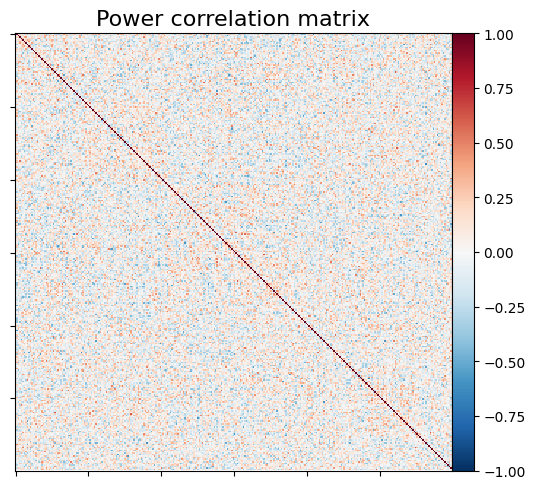

In [ ]:
from sklearn.preprocessing import StandardScaler



sample_row = bp_data.iloc[0]  # Change the index (0) to the desired sample

data_path = sample_row['data']
confounds_data = sample_row['confounds']

# Perform preprocessing on confounds_data if needed
confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)
timeseries = spheres_masker.fit_transform(data_path, confounds=confounds_data)

scaler = StandardScaler()

# Apply Z-score normalization to your time series data
timeseries_normalized = scaler.fit_transform(timeseries)

correlation_matrix = np.corrcoef(timeseries_normalized, rowvar=False)

# CONNECTOME MATRIX PLOTTING
plotting.plot_matrix(
    correlation_matrix,
    vmin=-1.0,
    vmax=1.0,
    colorbar=True,
    title="Power correlation matrix",
)

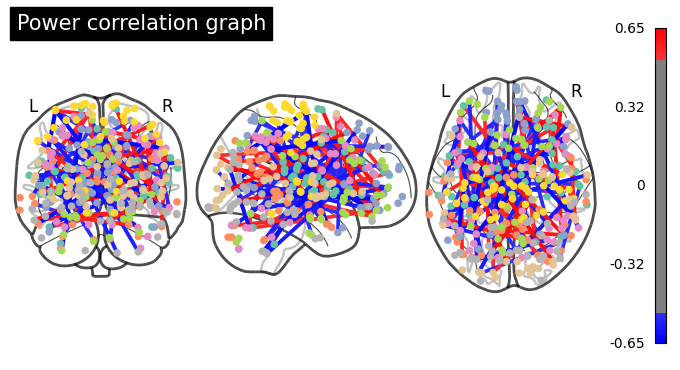

In [ ]:
# CONNECTOME PLOTTING
display =plotting.plot_connectome(
    correlation_matrix,
    coords,
    title="Power correlation graph",
    edge_threshold="99.8%",
    node_size=20,
    colorbar=True,
)

In [ ]:
power_correlation_matrix = correlation_matrix
G = nx.Graph()
n = power_correlation_matrix.shape[0]  # Number of brain regions

n = power_correlation_matrix.shape[0]
mask = ~np.eye(n, dtype=bool)

# Calculate the threshold based on the top 0.2% of values, excluding the diagonal
# Flatten the correlation matrix, excluding the diagonal
values = power_correlation_matrix[mask].flatten()

# Sort the values in descending order
sorted_values = np.sort(values)[::-1]

# Calculate the threshold
top_percentage = 0.5
threshold_idx = int(len(sorted_values) * top_percentage / 100)
threshold = sorted_values[threshold_idx]

for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        if abs(correlation_matrix[i, j]) >= threshold:
            G.add_edge(i, j)



In [37]:
G = control_data.at[9, 'graph']

pos = nx.spring_layout(G)
node_degrees = dict(G.degree())


# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure with size proportional to degree
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(x=[x], y=[y], mode="markers", marker=dict(size=2 * node_degrees[node], opacity=0.7), name=str(node_degrees[node])))

# Add edges to the figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1)))

# Customize the figure further as needed

# Show the interactive plot
fig.show()


In [38]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(node_degrees.values()) / num_nodes

# Print the results
print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Average Degree:", average_degree)

Number of Nodes: 207
Number of Edges: 292
Average Degree: 2.821256038647343


In [11]:
#@title Save dataframes as csv?
save_data = True # @param {type:"boolean"}
if save_data:
      # Save dataframes to files
      control_data.to_csv('control_data.csv', index=False)
      schz_data.to_csv('schz_data.csv', index=False)
      bp_data.to_csv('bp_data.csv', index=False)
      adhd_data.to_csv('adhd_data.csv', index=False)
      print('Dataframes saved!')

download_data = True # @param {type:"boolean"}
if download_data:
  from google.colab import files
  zip_file = '/content/dataframes.zip'
  !zip -r dataframes.zip /content/control_data.csv /content/schz_data.csv /content/bp_data.csv /content/adhd_data.csv
  files.download(zip_file)

Dataframes saved!
  adding: content/control_data.csv (deflated 71%)
  adding: content/schz_data.csv (deflated 71%)
  adding: content/bp_data.csv (deflated 71%)
  adding: content/adhd_data.csv (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Use precomputed

prec = False # @param {type:"boolean"}
if prec:
  control_data = pd.read_csv('/content/control_data.csv')
  schz_data = pd.read_csv('/content/schz_data.csv')
  bp_data = pd.read_csv('/content/bp_data.csv')
  adhd_data = pd.read_csv('/content/adhd_data.csv')


In [ ]:
gc.collect()

7452